# Numerical simulation of classical Ising model using the core interface

In this notebook, we will use OpenJij's core interface (core python interface) to perform numerical simulations of the Ising model with random interactions and random longitudinal magnetic fields.



First, we define Graph and $J_{ij}, h_i$ for the system you wish to simulate numerically.

In [17]:
import openjij.cxxjij.graph as G
# Set the problem size to 100
N = 100

graph = G.Dense(N)
# Use below for sparse
#graph = G.Sparse(N)

Next, we set $J_{ij}, h_i$.
We set the values generated from a Gaussian distribution with a mean of 0 and a standard deviation of 1.

In [3]:
# Use numpy for random number generation
# !pip install numpy

In [4]:
import numpy as np
mu, sigma = 0, 1

for i in range(N):
    for j in range(N):
        # Jij value would be too large, so we use 1/N for standardization.
        graph[i,j] = 0 if i == j else np.random.normal()/N

for i in range(N):
    graph[i] = np.random.normal()/N

The longitudinal magnetic field can be accessed either by `graph[i]` or by `graph[i,i]`.
$J_{ij}$ and $J_{ji}$ are automatically the same value by definition of the Ising model.
Let us try the following output.

In [5]:
graph[20] = 0.5
print(graph[20,20])
print(graph[20])
graph[12,34] = -0.6
print(graph[12,34])
print(graph[34,12])

0.5
0.5
-0.6
-0.6


## System

Next, define the system to perform the calculations.  

Here we want to perform a numerical simulation of the classical Ising model, so we create a system for that model with `system.make_classical_ising`.

In [6]:
import openjij.cxxjij.system as S

mysystem = S.make_classical_ising(graph.gen_spin(), graph)

Here, we assign a randomly generated spin to the first argument and the Graph itself to the second.
This creates a system of classical Ising models whose initial spin configuration is `graph.gen_spin()`.

We can also access the system directly and read the values.

In [7]:
print(mysystem.spin)

[ 1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1.
 -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1.  1. -1. -1. -1. -1.
  1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
  1. -1.  1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1.
  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.
 -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1.]


## Run the Algorithm with Updater

After defining the System, we select Updater and run the Algorithm.

### Updater

The Updater for the classical Ising model is mainly:

- [SingleSpinFlip](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/updater/single_spin_flip.hpp#L40) (update one spin at a time using the Metropolis-Hasting method)
- [SwendsenWang](https://github.com/OpenJij/OpenJij/blob/ec41aecfbac7e4c895e1e7a1718f06eb7ffae0ba/src/updater/swendsen_wang.hpp#L45) (cluster updates by the SwendsenWang method)

To run the Algorithm, you will need a **schedule list**.
Let us start by creating a schedule list.

### Algorithm

#### Schedule list

The schedule list is given as a list of `(parameters, number of Monte Carlo steps)`.
The value to be entered in the parameter depends on the System.
For example, for the classical Ising model, the parameter is the inverse temperature $\beta$.
Therefore, this refers to a list of temperature schedules.
Let us set the following example.

In [8]:
schedule_list = [(0.01, 10),(10, 80),(0.1, 30)]

This means that 10 Monte Carlo steps are performed at inverse temperature $\beta=0.01$, 80 steps at $\beta=10$, and 30 steps at $\beta=0.1$, for a total of 120 Monte Carlo steps.  
In annealing, the inverse temperature is often increased proportionally, so you can easily create a schedule by using the `make_classical_schedule_list` in the `utility`.
The temperature is changed in 10 steps from $\beta=0.1$ to $\beta=50$, with 20 Monte Carlo steps calculated at each temperature. A total of 200 Monte Carlo steps are calculated.

In [9]:
import openjij.cxxjij.utility as U
schedule_list = U.make_classical_schedule_list(0.1, 50, 20, 10)
print(schedule_list)

[((beta: 0.100000) mcs: 20), ((beta: 0.199474) mcs: 20), ((beta: 0.397897) mcs: 20), ((beta: 0.793701) mcs: 20), ((beta: 1.583223) mcs: 20), ((beta: 3.158114) mcs: 20), ((beta: 6.299605) mcs: 20), ((beta: 12.566053) mcs: 20), ((beta: 25.065966) mcs: 20), ((beta: 50.000000) mcs: 20)]


#### Run the Algorithm

By writing `Algorithm_[Updater]_run`, the calculation is performed with the specified Updater.
In the following example, `SingleSpinFlip` is executed.

In [10]:
import openjij.cxxjij.algorithm as A
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list)

The process is over instantly, but a total of 200 Monte Carlo steps have been computed during this time.
> `A.Algorithm_SingleSpinFlip_run(mysystem, seed, schedule_list)` allows you to run the calculation with the seed fixed. This can be used to make the results reproducible.

We use the callback to get the system for each 1 Monte Carlo step during the execution of the Algorithm.
For the classical Ising model, we create a function with the system and parameters (inverse temperature) as arguments.  
As an example, below we create a callback that records the value of the energy of the system.

In [11]:
energies = []

def callback_log_energy(system, beta):
    #graph is the object defined previously in the Graph module
    energies.append(graph.calc_energy(system.spin))

The same Algorithm is executed using this callback.

In [12]:
#Take a longer schedule (total of 20000 Monte Carlo steps)
schedule_list = U.make_classical_schedule_list(0.1, 50, 200, 100)
A.Algorithm_SingleSpinFlip_run(mysystem, schedule_list, callback_log_energy)

The recorded system energy is plotted with Monte Carlo steps on the horizontal axis and energy on the vertical axis as follows:

In [14]:
# !pip install matplotlib

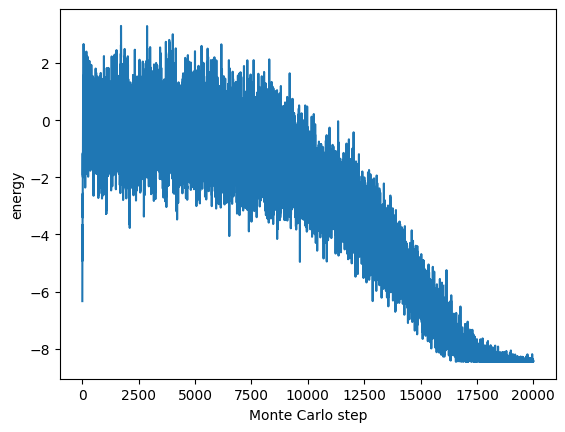

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(len(energies)), energies)
plt.xlabel('Monte Carlo step')
plt.ylabel('energy')
plt.show()

The energy is gradually decreasing as the annealing proceeds.
Thus, the callback is useful to know how the system looks like while the Algorithm is running.

## Result

With `result.get_solution` we get the spin sequence that is the result of the calculation.
For the classical Ising model, we can also directly refer to `mysystem.spin` to get the spin sequence.
However, `result.get_solution` is a convenient method to do so for other systems as well.

In [16]:
import openjij.cxxjij.result as R
print(R.get_solution(mysystem))

[-1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, 1]


This spin sequence is the answer obtained by annealing.
It is expected to be the ground state (close to the ground state) of the Hamiltonian.